# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy

from helpers.normalization import normalize, denormalize, renormalize
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.


In [2]:
%matplotlib inline
font={'family': 'Times New Roman',
      'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

# Analysis

In [18]:
file_path='/home/wconlin/run_results/model-conv1d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_01Oct19-08-59_Scenario-480.h5'
#file_path='/home/wconlin/run_results/model-conv2d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_28Sep19-01-56_Scenario-128.h5'
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv1d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_01Oct19-08-59_Scenario-480.h5
loaded dict: model-conv1d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_01Oct19-08-59_Scenario-480_params.pkl
with parameters: dict_keys(['model_type', 'epochs', 'actuator_names', 'scalar_input_names', 'flattop_only', 'input_profile_names', 'target_profile_names', 'batch_size', 'process_data', 'predict_deltas', 'profile_downsample', 'model_kwargs', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac',

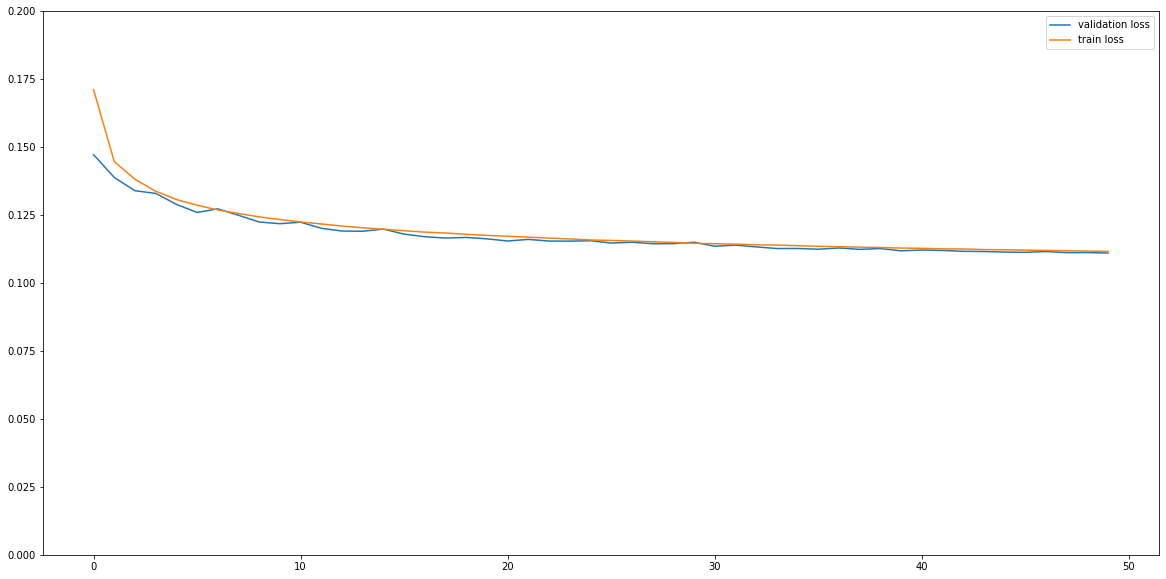

In [21]:
plt.plot(scenario['history']['val_loss'],label='validation loss')
plt.plot(scenario['history']['loss'],label='train loss')
plt.legend()
plt.ylim(0,.2)
plt.show()

In [22]:
traindata, valdata, normalization_dict = process_data('/scratch/gpfs/jabbate/test_data/final_data.pkl', #scenario['raw_data_path'],
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2,
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'])

Loading
Signals: curr, dens, density_estimate, gasA, pinj, temp, tinj
Number of useable shots:  818
Number of shots used:  818
Total number of timesteps:  218579
Shots with Complete NaN: [179109.], [179113.], [179115.], [179117.], [179198.], [179317.], [179318.], [179330.], [179381.], [179395.], [179397.], [179406.], [179408.], [179409.], [179411.], [180124.]
50619 samples total
Removing NaN
Removed 0 samples
50619 samples remaining
Removing dudtrip
Removed 481 samples
50138 samples remaining
Removing weird I-coils
Removed 9008 samples
41130 samples remaining
Removing ECH
Removed 19643 samples
21487 samples remaining
Removing weird gas
Removed 5151 samples
16336 samples remaining
Removing ECH
Removed 0 samples
16336 samples remaining
Removing weird gas
Removed 0 samples
16336 samples remaining
16336 samples remaining after pruning
nonrandomized
Total number of samples:  16336
Number of training samples:  16336
Number of validation samples:  0


In [23]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False) #scenario['shuffle_generators'])

# Design your own shot

In [76]:
plt.rcParams["figure.figsize"] = (20,10)

def plot_prediction_for_shot_at_time(shotnum,t,filename=None):

    psi = np.linspace(0,1,scenario['profile_length'])
    sigs=['curr','pinj','tinj','gasA']
    profiles=['temp','dens']
    input_profiles=['temp','dens'] #['thomson_temp_EFITRT1','thomson_dens_EFITRT1']
    changed_input_keys=[]
    changed_profile_keys=[] #'thomson_dens_EFITRT1']

    shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]

    time_offset=np.argmin(abs(traindata['time'][shot_indices,-scenario['lookahead']]-t))

    #prev_targets=train_generator[shot_indices[0]+time_offset-1][1]

    inputs=train_generator[shot_indices[0]+time_offset][0]
    targets=train_generator[shot_indices[0]+time_offset][1]
    
    changed_input=copy.deepcopy(inputs)
    for key in changed_input_keys:
        #changed_input['input_past_{}'.format(key)]=np.array([np.linspace(-2,0,actuator_lookback)])
        #changed_input['input_future_{}'.format(key)]-=[0,.5,1,1.5]

        prev=traindata[key][shot_indices[0]+time_offset][-scenario['lookahead']]
        changed_input['input_future_{}'.format(key)]=np.array([[prev]*scenario['lookahead']])
        #changed_input['input_future_{}'.format(key)]=np.array([np.linspace(prev,prev+2,scenario['lookahead'])]) 
        #prev=traindata[key][shot_indices[0]+time_offset][-1]#0]
        #changed_input['input_past_{}'.format(key)]=np.array([[prev]*actuator_lookback])

    for key in changed_profile_keys:
        #changed_input['input_{}'.format(key)]=np.array([[[0]*scenario['profile_length']]])
        #changed_input['input_{}'.format(key)]-=np.array([[.5*np.linspace(1,1,scenario['profile_length'])]])
        changed_input['input_{}'.format(key)]+=np.array([targets['target_{}'.format(key)]])
    
    num_cols=4

    fig=plt.figure()
    for i,sig in enumerate(sigs):
        ax=fig.add_subplot(len(sigs),num_cols,i*num_cols+1)
        if len(traindata[sig][shot_indices].shape)>2:
            ax.plot(traindata['time'][shot_indices,-scenario['lookahead']],
                    np.mean(traindata[sig][shot_indices,-scenario['lookahead'],:],axis=1),
                    c='b')
    #         ax.contourf(traindata['time'][shot_indices,-lookahead],
    #                 psi,
    #                 traindata[sig][shot_indices,-lookahead,::scenario['profile_downsample']].T)
            ax.set_ylim(-2,2)

        else:
            ax.plot(traindata['time'][shot_indices[0],:-scenario['lookahead']],
                            traindata[sig][shot_indices[0],:-scenario['lookahead']],
                   c='b')
            ax.plot(traindata['time'][shot_indices,-scenario['lookahead']],
                            traindata[sig][shot_indices,-scenario['lookahead']],
                   c='b')
            if sig in changed_input_keys:
                ax.plot(traindata['time'][shot_indices[0]+time_offset,-scenario['lookahead']:],
                       changed_input['input_future_{}'.format(sig)].squeeze(),
                       color='r')
                try:
                    ax.plot(traindata['time'][shot_indices[0]+time_offset,:-scenario['lookahead']],
                           changed_input['input_past_{}'.format(sig)].squeeze(),
                           color='r')
                except:
                    pass
            if sig=='curr':
                ax.set_ylim(-6,6)
            else:
                ax.set_ylim(-2,2)


        ax.axvline(traindata['time'][shot_indices[0]+time_offset,-scenario['lookahead']],
                  color='r')
        ax.axvline(traindata['time'][shot_indices[0]+time_offset,-1],
                  color='g')
        ax.axvline(traindata['time'][shot_indices[0]+time_offset,0],
                  color='k')
        ax.set_xlim(0,np.amax(traindata['time'][shot_indices]))
        ax.set_title(sig)

    # truths=train_generator[shot_indices[0]+time_offset][1]

    for i,profile in enumerate(input_profiles):
        ax=fig.add_subplot(len(input_profiles),num_cols,i*num_cols+1+1)

        ax.plot(psi,inputs['input_{}'.format(profile)].squeeze(),c='g')
        if profile in changed_profile_keys:
            ax.plot(psi,changed_input['input_{}'.format(profile)].squeeze(),c='r')
        ax.set_title('{}'.format(profile))
        ax.axhline(0,color='k',alpha=.5)
        ax.set_ylim(-2,2)

    predictions=model.predict_on_batch(inputs)
    changed_predictions=model.predict_on_batch(changed_input)
    for i,profile in enumerate(profiles):
        ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1+1)

        if scenario['predict_deltas']:
            ax.plot(psi,targets['target_{}'.format(profile)].squeeze(),label='True',c='g')
            ax.plot(psi,predictions[i].squeeze(),label='Prediction',
                    c='b')
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,changed_predictions[i].squeeze(),color='r',label='Perturbed Prediction')
        else:
            ax.plot(psi,
                    targets['target_{}'.format(profile)].squeeze()-traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
                    label='True',
                    c='g')
            ax.plot(psi,
                    predictions[i].squeeze()-traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
                    label='Prediction',
                    c='b')
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        changed_predictions[i].squeeze()-traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
                        color='r',
                        label='Perturbed Prediction')

        ax.set_title('{} change'.format(profile))
        ax.axhline(0,color='k',alpha=.5)
        ax.set_ylim(-2,2)
        ax.legend()

        ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1+1+1)
        ax.plot(psi,
                traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
                label='Previous',
                c='k')
        ax.plot(psi,
                traindata[profile][shot_indices[0]+time_offset][-1][::scenario['profile_downsample']],
                label='Next',
                c='g')
        if scenario['predict_deltas']:
            ax.plot(psi,
                    traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+predictions[i].squeeze(),
                    label='Prediction',
                    c='b')
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+changed_predictions[i].squeeze(),
                        label='Perturbed Prediction',
                        c='r')
        else:
            ax.plot(psi,
                    predictions[i].squeeze(),
                    label='Prediction',
                    c='b')
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        changed_predictions[i].squeeze(),
                        label='Perturbed Prediction',
                        c='r')
        ax.legend()
        ax.set_title(profile)
        ax.set_ylim(-2,2)
        ax.axhline(0,color='k',alpha=.5)

    time=train_generator.cur_times[:,max(scenario['profile_lookback'], scenario['actuator_lookback'])].squeeze()
    fig.suptitle('Shot {:.0f}, {:.0f} ms'.format(shotnum,time),fontsize=30)
    plt.subplots_adjust(hspace=.2)
    if filename is None:
        plt.show()
    else:
        print(filename)
        plt.savefig(filename)
        plt.close()

In [25]:
train_generator[0][0].keys()

dict_keys(['input_temp', 'input_dens', 'input_past_pinj', 'input_future_pinj', 'input_past_curr', 'input_future_curr', 'input_past_tinj', 'input_future_tinj', 'input_past_gasA', 'input_future_gasA', 'input_density_estimate'])

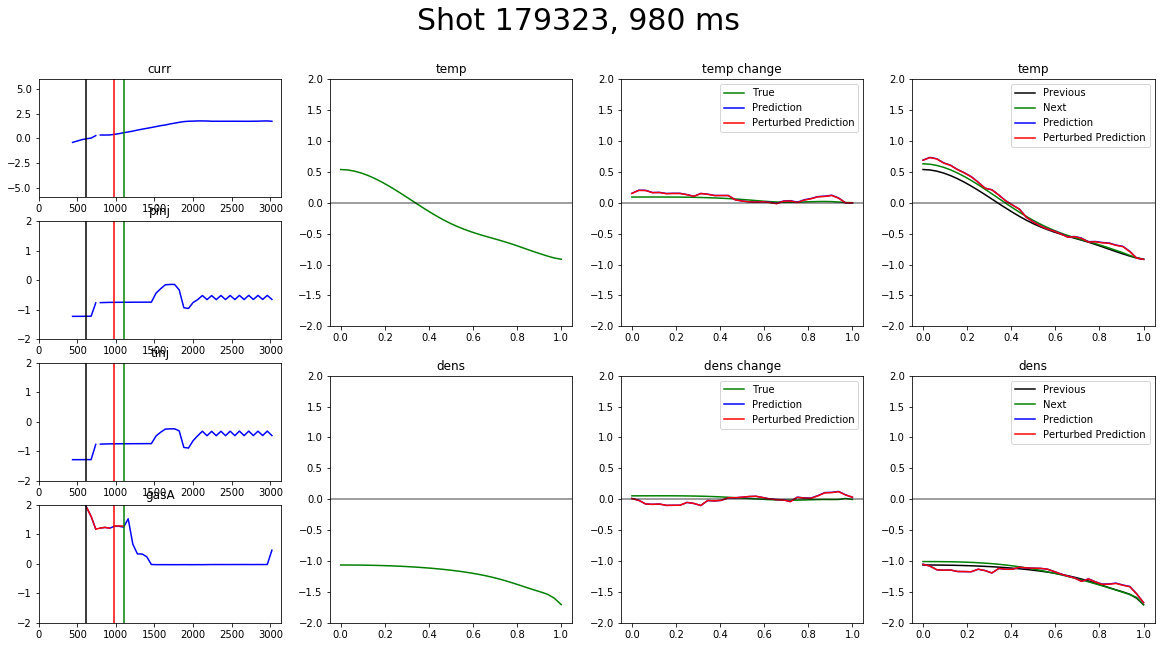

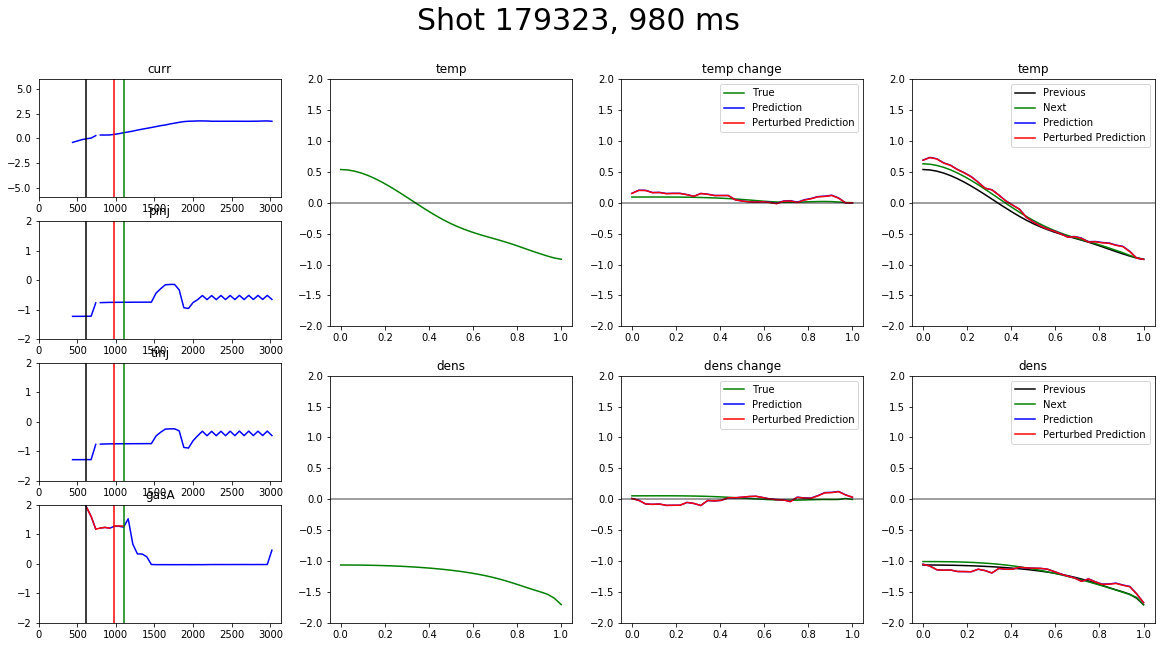

In [39]:
plt.rcParams["figure.figsize"] = (20,10)


all_shots=np.unique(traindata['shotnum'])
shotnum=179323 #np.random.choice(all_shots)
t=1000 #np.random.choice([1000,1500,2000])
#plot_prediction_for_shot_at_time(shotnum,t)

In [78]:
basedir='/home/jabbate/pics'

shotnum=np.random.choice(all_shots)
shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]
time_offset=abs(traindata['time'][shot_indices,-scenario['lookahead']])
for i,t in enumerate(time_offset):
    plot_prediction_for_shot_at_time(shotnum,t,filename=os.path.join(basedir,'{}_{:02d}.png'.format(int(shotnum),i)))

/home/jabbate/pics/180402_00.png
/home/jabbate/pics/180402_01.png
/home/jabbate/pics/180402_02.png
/home/jabbate/pics/180402_03.png
/home/jabbate/pics/180402_04.png
/home/jabbate/pics/180402_05.png
/home/jabbate/pics/180402_06.png
/home/jabbate/pics/180402_07.png
/home/jabbate/pics/180402_08.png


In [73]:
print()

[ 800.  860.  920.  980. 1040. 1100. 1160. 1220. 1280. 1340. 1400. 1460.
 1520. 1580. 1640. 1700. 1760. 1820. 1880. 1940. 2000. 2060. 2120. 2180.
 2240. 2300. 2360. 2420. 2480. 2540. 2600. 2660. 2720. 2780. 2840. 2900.
 2960. 3020.]


# Make the colorbar plots

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['font.size'] = 22

import numpy as np
import matplotlib.pyplot as plt

shots=list(data.keys())
shot=170701 #np.random.choice(shots)
sigs=['curr','temp','pinj','tinj','dens','gasA','ech'] #['ffprime_EFITRT1','curr_target','pinj','temp','dens','gas_feedback','target_density','gasA','gasA_voltage', 'beam_feedback_switch', 'beam_feedback_power_target_quantity', 'realtime_betan']
sig_names={'curr': 'Current\n(MA)',
           'temp':'Electron Temperature\n(keV)', 
           'dens': 'Electron Density\n(10^19 cm^-3)',
           'itemp':'Ion Temperature\n(keV)', 
           'pinj': 'NB Power\n(MW)', 
           'gasA': 'Gas\n(V)',
           'ech': 'ECH Power\n(MW)',
           'tinj': 'NB Torque\n(Rad/s)'}
conversion_factor={'temp': 1000,
                  'dens':1e19,
                  'pinj': 1000,
                  'tinj': 1,
                  'curr': 1e6,
                  'gasA': 1,
                  'ech': 1}

#sigs=['curr_target','pinj','temp','dens','target_source_pinj_30L','beam_feedback_switch','beam_feedback_switch','beam_feedback_power_target_quantity','beam_feedback_power_target_value','realtime_betan']
assert(all(data[shot]['gas_density_or_profile_algorithm']==0))

def removeOutliers(x, outlierConstant, sig):
    #upper_quartile = np.nanpercentile(x, 75)
    #lower_quartile = np.nanpercentile(x, 25)
    upper_quartile=quartiles[sig]['upper']
    lower_quartile=quartiles[sig]['lower']
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    return np.clip(x,lower_quartile - IQR,upper_quartile + IQR)


def my_normalize(arr):
    return (arr-np.nanmin(arr))/(np.nanmax(arr)-np.nanmin(arr))

fig=plt.figure()
for i,sig in enumerate(sigs):
    ax=fig.add_subplot(len(sigs),1.5,i+1)
    ax.axvline(data[shot]['t_ip_flat'],c='r')
    ax.axvline(data[shot]['t_ip_flat']+data[shot]['ip_flat_duration'],c='r')
    if sig in ['temp','dens']: #len(data[shot][sig].shape)>1:
        #thomson_sig_name='thomson_{}_EFITRT1'.format(sig)
        #thomson_sig=data[shot][thomson_sig_name]
        #thomson_sig=removeOutliers(thomson_sig,1.5,thomson_sig_name)
        #ax.plot(data[shot]['time'],my_normalize(data[shot]['pinj']),c='r')
            
        zipfit_sig=np.mean(data[shot][sig],axis=1) #my_normalize(np.mean(data[shot][sig],axis=1))
        
        ax.contourf(data[shot]['time'],
            np.linspace(0,np.nanmax(data[shot][sig]),65),
            #thomson_sig.T)
            data[shot][sig].T)
        
        ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
        ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3,label='Fitted')
        
        #thomson_sig=np.mean(thomson_sig,axis=1)/conversion_factor[sig] #my_normalize(np.mean(thomson_sig,axis=1))
        #ax.plot(data[shot]['time'],thomson_sig,c='b',linewidth=7,label='Raw Thomson')
        #ax.legend()
        #ax.plot(data[shot]['time'],my_normalize(np.mean(data[shot]['thomson_{}_EFITRT1'.format(sig)],axis=1), clip=True, sig=sig),c='g',linewidth=3)
    elif len(data[shot][sig].shape)>1:
        thomson_sig=removeOutliers(data[shot][sig],1.5,sig)
        
        ax.contourf(data[shot]['time'],
                    np.linspace(0,1,65),
                    #thomson_sig.T)
                    data[shot][sig].T)
            
#         zipfit_sig=my_normalize(np.mean(data[shot][sig],axis=1))
#         ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
#         ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3)
        
       
    elif sig=='target_density':
        ax.plot(data[shot]['time'],data[shot]['density_estimate'])
        ax.plot(data[shot]['time'],data[shot]['target_density'],c='r')
    elif sig=='realtime_betan':
        ax.plot(data[shot]['time'],data[shot]['realtime_betan'])
        ax.plot(data[shot]['time'],data[shot]['beam_feedback_power_target_value'],c='r')
    elif sig=='curr_target':
        ax.plot(data[shot]['time'],data[shot]['curr'])
        ax.plot(data[shot]['time'],data[shot]['curr_target'],c='r')
        
    else:
        ax.plot(data[shot]['time'],data[shot][sig]/conversion_factor[sig])
    ax.set_ylabel(sig_names[sig])
    ax.set_xlim(min(data[shot]['time']),max(data[shot]['time']))
    #ax.axvline(2220)
    #ax.axvline(2270)
plt.xlabel('Time (ms)')
#plt.subplots_adjust(hspace=.5)
fig.suptitle('Shot {}'.format(shot),fontsize=30)
plt.show()